In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.layers import TextVectorization
import nltk

seed = 111
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
IMAGES_PATH = r"D:\MO3 LAP\Datasets\Manually captioned data for gp\Merged_Images"
IMAGE_SIZE = (299, 299)


VOCAB_SIZE = 11000


SEQ_LENGTH = 27  # max seqence length


EMBED_DIM = 512


FF_DIM = 512


BATCH_SIZE = 48


EPOCHS = 40


AUTOTUNE = tf.data.AUTOTUNE

In [3]:
def load_captions_data(filename):
    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            img_name, caption = line.split(",", 1)  # Split only at the first comma
            if img_name.startswith("Esraa_") and not img_name.startswith("Esraa_to"):
                img_name = img_name.replace("jpg", "jfif")
            if img_name.startswith("image_"):
                img_name = img_name.replace("jpg", "png")
            img_name = img_name.split("#")[0]
            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            tokens = caption.strip().split()

            if len(tokens) < 0 or len(tokens) > SEQ_LENGTH:
                images_to_skip.add(img_name)
                continue

            if (
                img_name.endswith("jpg")
                or img_name.endswith("jfif")
                or img_name.endswith("png")
            ) and img_name not in images_to_skip:
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data


def train_val_split(caption_data, train_size=0.8, shuffle=True):
    all_images = list(caption_data.keys())

    if shuffle:
        np.random.shuffle(all_images)

    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    return training_data, validation_data


captions_mapping, text_data = load_captions_data(
    r"D:\MO3 LAP\Datasets\Manually captioned data for gp\merged_captions.txt"
)
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  7219
Number of validation samples:  1805


In [4]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")
vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)


def preprocess_text(text):
    try:
        return text.encode("utf-8").decode("utf-8")
    except UnicodeDecodeError as e:
        print(f"UnicodeDecodeError: {e} in text: {text}")
        return ""


# Preprocess the data
processed_data = [preprocess_text(text) for text in text_data]

vectorization.adapt(text_data)
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)

In [5]:
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)


"""def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return dataset


train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))

valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))"""

'def make_dataset(images, captions):\n    dataset = tf.data.Dataset.from_tensor_slices((images, captions))\n    dataset = dataset.shuffle(BATCH_SIZE * 8)\n    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)\n    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)\n    return dataset\n\n\ntrain_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))\n\nvalid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))'

In [6]:
def get_cnn_model():
    base_model = EfficientNetV2B3(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
    )

    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(  # self attention
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(  # cross attention mechanism
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self,
        cnn_model,
        encoder,
        decoder,
        num_captions_per_image=5,
        image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[
            :, :-1
        ]  # take all but the last token , same as batch_seq[:,:,:-1]
        batch_seq_true = batch_seq[:, 1:]  # all but the first token
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        img_embed = self.cnn_model(batch_img)

        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                batch_loss += loss
                batch_acc += acc

            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            grads = tape.gradient(loss, train_vars)

            self.optimizer.apply_gradients(zip(grads, train_vars))

        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0
        img_embed = self.cnn_model(batch_img)
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )
            batch_loss += loss
            batch_acc += acc
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=image_augmentation,
)

In [8]:
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=4e-4, warmup_steps=num_warmup_steps)
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)
caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    # callbacks=[early_stopping],
)

Epoch 1/40
151/151 [==============================] - 110s 611ms/step - loss: 23.2749 - acc: 0.1912 - val_loss: 17.0628 - val_acc: 0.3699
Epoch 2/40
151/151 [==============================] - 66s 435ms/step - loss: 16.1595 - acc: 0.3715 - val_loss: 15.6283 - val_acc: 0.3957
Epoch 3/40
151/151 [==============================] - 66s 438ms/step - loss: 14.4680 - acc: 0.4055 - val_loss: 15.1287 - val_acc: 0.4059
Epoch 4/40
151/151 [==============================] - 66s 439ms/step - loss: 13.2666 - acc: 0.4313 - val_loss: 15.1562 - val_acc: 0.4094
Epoch 5/40
151/151 [==============================] - 66s 438ms/step - loss: 12.2602 - acc: 0.4546 - val_loss: 15.2614 - val_acc: 0.4082
Epoch 6/40
151/151 [==============================] - 66s 440ms/step - loss: 11.3985 - acc: 0.4777 - val_loss: 15.4126 - val_acc: 0.4098
Epoch 7/40
151/151 [==============================] - 66s 436ms/step - loss: 10.6203 - acc: 0.4999 - val_loss: 15.7636 - val_acc: 0.4068
Epoch 8/40
151/151 [====================

In [ ]:
import json


# caption_model.save_weights("weights/8k_EfficientNetV2B3_Eng_3onf_bs_merged_weights")


# with open('weights/basic_vocab.json', 'w') as vocab_file:


# json.dump(index_lookup, vocab_file)

In [19]:
index_lookup[2]

'a'

In [7]:
caption_model.load_weights("weights/8k_EfficientNetV2B3_Eng_3onf_bs_merged_weights")

In [8]:
import pickle

"""vocab = vectorization.get_vocabulary()
with open("weights/8k_EfficientNetV2B3_Eng_3onf_bs_merged_vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)"""

In [8]:
import pickle

# Load the list from the file
with open("weights/8k_EfficientNetV2B3_Eng_3onf_bs_merged_vocab.pkl", "rb") as f:
    vocab = pickle.load(f)

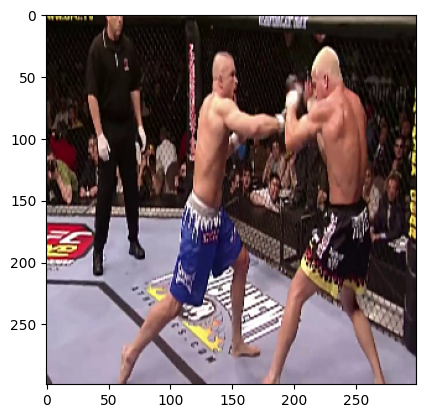

Predicted Caption:  a man in black shorts is beaten by a man in blue shorts


In [11]:
index_lookup = dict(zip(range(len(vocab)), vocab))


max_decoded_sentence_length = SEQ_LENGTH - 1
#valid_images = list(valid_data.keys())


def generate_caption():

    sample_img = (
        r"D:\MO3 LAP\Datasets\Manually captioned data for gp\test\Arwa_103.jpg"
    )
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    encoded_img = caption_model.encoder(img, training=False)
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):

        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption)


generate_caption()

In [9]:
# Generate captions for a set of images
def generate_captions_for_images(image_paths):
    captions = []
    for image_path in image_paths:
        img = decode_and_resize(image_path)
        img = tf.expand_dims(img, 0)
        img = caption_model.cnn_model(img)
        encoded_img = caption_model.encoder(img, training=False)
        decoded_caption = "<start> "
        for i in range(max_decoded_sentence_length):
            tokenized_caption = vectorization([decoded_caption])[:, :-1]
            mask = tf.math.not_equal(tokenized_caption, 0)
            predictions = caption_model.decoder(
                tokenized_caption, encoded_img, training=False, mask=mask
            )
            sampled_token_index = np.argmax(predictions[0, i, :])
            sampled_token = index_lookup[sampled_token_index]
            if sampled_token == "<end>":
                break
            decoded_caption += " " + sampled_token
        decoded_caption = decoded_caption.replace("<start> ", "")
        decoded_caption = decoded_caption.replace(" <end>", "").strip()
        captions.append(decoded_caption)
    return captions

In [32]:
candidate = ["a man is resting his skis through the woods"]
reference = [
    "man in hat is displaying pictures next to skier in blue hat",
    "man skis past another man displaying paintings in the snow",
    "person wearing skis looking at framed pictures set up in the snow",
    "skier looks at framed pictures in the snow next to trees",
    "man on skis looking at artwork for sale in the snow",
]


candidates = [
    "a man is resting his skis through the woods",
    "a little girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it",
    "a black dog and a spotted dog are fighting",
]
references = [
    [
        "man in hat is displaying pictures next to skier in blue hat",
        "man skis past another man displaying paintings in the snow",
        "person wearing skis looking at framed pictures set up in the snow",
        "skier looks at framed pictures in the snow next to trees",
        "man on skis looking at artwork for sale in the snow",
    ],
    [
        "little girl covered in paint sits in front of painted rainbow with her hands in bowl",
        "little girl is sitting in front of large painted rainbow",
        "small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it",
        "there is girl with pigtails sitting in front of rainbow painting",
        "young girl with pigtails painting outside in the grass",
    ],
    [
        "black dog and spotted dog are fighting",
        "black dog and tri-colored dog playing with each other on the road",
        "black dog and white dog with brown spots are staring at each other in the street",
        "two dogs of different breeds looking at each other on the road",
        "two dogs on pavement moving toward each other",
    ],
]

In [55]:
"""
Candidate sentence: “a little girl is sitting in front of a rainbow painting”
Reference sentences: [“little girl covered in paint sits in front of painted rainbow with her hands in bowl”]
 
-Longest Common Subsequence (LCS): The LCS between the candidate sentence and the first reference sentence is “little girl in front of rainbow”.
 So, the length of LCS is 6.

-Precision: This is the ratio of the length of LCS to the length of the candidate sentence. The length of the candidate sentence is 9.
 So, the precision is 6/9 = 0.67.
 
-Recall: This is the ratio of the length of LCS to the length of the reference sentence. The length of the first reference sentence is 13.
 So, the recall is 6/13 = 0.46.

-F-measure: This is the harmonic mean of precision and recall.
 So, the F-measure is 2 * (0.67 * 0.46) / (0.67 + 0.46) = 0.55.

-ROUGE-L = 0.55
"""


def ROUGEL(candidate, references):
    from rouge_score import rouge_scorer

    max_scores = []
    image_number = 1
    for refs, cand in zip(references, candidate):
        scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
        scores = [scorer.score(cand, ref)["rougeL"].fmeasure for ref in refs]
        i = 1
        for score in scores:
          print(f"ROUGEL -> Image #{image_number} Reference #{i}: {score*100:.0f}")
          i += 1
        image_number += 1
        max_scores.append(max(scores))

    return max_scores

"""mx = ROUGEL(candidate, reference)
print("MAX ROUGE-L score: ", mx)"""

'mx = ROUGEL(candidate, reference)\nprint("MAX ROUGE-L score: ", mx)'

In [56]:
def METEOR(candidates, references):
    import nltk

    max_scores = []
    image_number = 1
    for refs, cand in zip(references, candidates):

        meteor_scores = []

        tokanized_cand = cand.split(" ")
        
        for ref in refs:

            tokanized_ref = ref.split(" ")

            result = nltk.translate.meteor_score.meteor_score(
                [tokanized_ref], tokanized_cand
            )

            meteor_scores.append(result)
        i = 1
        for score in meteor_scores:
          print(f"METEOR -> Image #{image_number} Reference #{i}: {score*100:.0f}")
          i += 1
        image_number += 1
        max_scores.append(max(meteor_scores))

    return max_scores


"""mxm = METEOR(candidate, reference)


print(mxm)"""

'mxm = METEOR(candidate, reference)\n\n\nprint(mxm)'

In [36]:
def calculate_bleu_scores(references, candidates):
    bleu_scores = []
    for ref, cand in zip(references, candidates):
        # Convert the reference sentences to lists of words
        references = [ref.split() for ref in ref]
        
        
        candidate = cand.split()  # Convert the candidate sentence to a list of words
        # Calculate BLEU score
        bleu = nltk.translate.bleu_score.sentence_bleu(references, candidate)
        bleu_scores.append(bleu)
        
    return bleu_scores

In [39]:
test_image_paths = [
    r"D:/MO3 LAP/Datasets/Flickr 8k Dataset/Images/3741462565_cc35966b7a.jpg",
    r"D:/MO3 LAP/Datasets/Flickr 8k Dataset/Images/3718305988_fe2c91fd44.jpg",
    r"D:/MO3 LAP/Datasets/Flickr 8k Dataset/Images/3726025663_e7d35d23f6.jpg",
    r"D:/MO3 LAP/Datasets/Flickr 8k Dataset/Images/3710674892_857b8056f7.jpg",
    r"D:/MO3 LAP/Datasets/Flickr 8k Dataset/Images/3697456750_460aea7252.jpg",
    r"D:/MO3 LAP/Datasets/Flickr 8k Dataset/Images/3692892751_f6574e2700.jpg",
    r"D:/MO3 LAP/Datasets/Flickr 8k Dataset/Images/3690425778_3b390b3ea5.jpg",
    r"D:/MO3 LAP/Datasets/Flickr 8k Dataset/Images/3677964239_6406ed096f.jpg",
    r"D:/MO3 LAP/Datasets/Flickr 8k Dataset/Images/3673484638_dce87295fe.jpg",
    r"D:/MO3 LAP/Datasets/Flickr 8k Dataset/Images/3662406028_29b9e46a6f.jpg",
]


generated_captions = generate_captions_for_images(test_image_paths)


reference_captions = [
    [
        "A little girl wearing a pink shirt is sitting at the table and drinking a milkshake",
        "A small young girl in a pink shirt drinking a large chocolate milkshake .",
        "A young girl dressed in pink with a hair barrette pursing her lips at a big chocolate milkshake .",
        "A young girl is staring at a large milkshake in a glass .",
        "A young girl looks excitedly at a large milkshake .",
    ],
    [
        "A jogger runs up brick stairs for streght training .",
        "A man is skating down a set of stairs .",
        "A skateboarder jumps on brick stairs .",
        "A young man skateboards around the empty outdoor sports arena .",
        "The man is skateboarding on a large brick staircase .",
    ],
    [
        "A group of people ride in a race",
        "A large group of bicycles riding their bikes .",
        "Bicycles in a race .",
        "Bikers participate in a race .",
        "There are many men racing on their bicycles .",
    ],
    [
        "A boy holds a green apple in his mouth .",
        "A boy wearing a life jacket has an apple in his mouth .",
        "A child is holding an apple in his mouth",
        "A young child in a life jacket eats a green apple .",
        "child with a green apple in his mouth is wearing a red life jacket",
    ],
    [
        "Girls fighting on karate competition .",
        "Two girls are kicking each other in martial arts uniforms .",
        "Two people are performing karate at a tournament .",
        "Two woman are doing karate .",
        "Two women in their karate uniforms kick at one another .",
    ],
    [
        "A man does a trick on his skateboard in front of a crowd .",
        "A skateboarder without a shirt grabs his board in the air .",
        "A young man shocks the audience with his skateboard tricks .",
        "Man with no shirt and tatoos on back airborne with skateboard in hand .",
        "The skateboarder performs a jump in front of a crowd of spectators .",
    ],
    [
        "A man jumps off of a dock and into the water .",
        "A person jumping off a dock into water .",
        "Person jumping into the water .",
        "The boy jumps into the water off of a dock .",
        "The person wearing shorts and a shirt is jumping off a dock , into the water .",
    ],
    [
        "a few girls on a woooden pier eating ice cream cones",
        "A young girl enjoys ice cream with two older women in a pier-like setting .",
        "Two older women and a little girl standing outside under flowers .",
        "Two women and a little girl are eating ice cream .",
        "Two women and child eat ice cream cones on bridge decorated with flowers .",
    ],
    [
        "The two children , one with a scarf tied around their forehead , walk down a modeling runway .",
        "Two boys are walking along the stage whilst being watched by several people .",
        "Two children walking on a platform .",
        "Two children wearing denim walk on a runway .",
        "Two little kids walk the catwalk showing off their fashion .",
    ],
    [
        "A man wearing a formal suit and hat stands next to a building .",
        "a man wearing a tuxedo and top hat standing outside with some other people to hi right",
        "Two men dressed up walk along the street while another man stares at them .",
        "Two men in top hats and tuxedos are walking past a dry cleaning store and a casual man who is looking at them .",
        "Two men in tuxedos and top-hats stand on the street as a boy with backpack passes by",
    ],
]

In [40]:
for c in generated_captions:
    print(c)

a little girl is staring at the camera
a man skateboards around the empty outdoor sports arena
a group of men racing on their bicycles
a child is playing with his toy
a man in white performing a dance studio
a man shocks the audience with his skateboard tricks
a person jumping off of a dock and into the water
two women and a little girl are eating ice cream
two children walking on a platform
a man wearing a hat and formal suit and hat stands next to a building


In [17]:
import os
import shutil

test_image_paths = [
    r"D:\MO3 LAP\Datasets\Manually captioned data for gp\test\Arwa_103.jpg",
    r"D:\MO3 LAP\Datasets\Manually captioned data for gp\test\1719497696319.jpg",
    r"D:\MO3 LAP\Datasets\Manually captioned data for gp\test\Arwa_116.jpg",
    r"D:\MO3 LAP\Datasets\Manually captioned data for gp\test\Arwa_236.jpg",
    r"D:\MO3 LAP\Datasets\Manually captioned data for gp\test\1719497696392.jpg",
    r"D:\MO3 LAP\Datasets\Manually captioned data for gp\test\1719497696416.jpg",
    r"D:\MO3 LAP\Datasets\Manually captioned data for gp\test\1719497696440.jpg",
    r"D:\MO3 LAP\Datasets\Manually captioned data for gp\test\Esraa_171.jfif",
    r"D:\MO3 LAP\Datasets\Manually captioned data for gp\test\Esraa_to_YM_56.jpg",
    r"D:\MO3 LAP\Datasets\Manually captioned data for gp\test\1719497696528.jpg",
    
    r"D:/MO3 LAP/Datasets/Flickr 8k Dataset/Images/3741462565_cc35966b7a.jpg",
    r"D:/MO3 LAP/Datasets/Flickr 8k Dataset/Images/3718305988_fe2c91fd44.jpg",
    r"D:/MO3 LAP/Datasets/Flickr 8k Dataset/Images/3726025663_e7d35d23f6.jpg",
    r"D:/MO3 LAP/Datasets/Flickr 8k Dataset/Images/3710674892_857b8056f7.jpg",
    r"D:/MO3 LAP/Datasets/Flickr 8k Dataset/Images/3697456750_460aea7252.jpg",
    r"D:/MO3 LAP/Datasets/Flickr 8k Dataset/Images/3692892751_f6574e2700.jpg",
    r"D:/MO3 LAP/Datasets/Flickr 8k Dataset/Images/3690425778_3b390b3ea5.jpg",
    r"D:/MO3 LAP/Datasets/Flickr 8k Dataset/Images/3677964239_6406ed096f.jpg",
    r"D:/MO3 LAP/Datasets/Flickr 8k Dataset/Images/3673484638_dce87295fe.jpg",
    r"D:/MO3 LAP/Datasets/Flickr 8k Dataset/Images/3662406028_29b9e46a6f.jpg",
]
destination_folder = r"D:\MO3 LAP\Datasets\Manually captioned data for gp\test\images"

# Move images
for source_path in test_image_paths:
    filename = os.path.basename(source_path)
    destination_path = os.path.join(destination_folder, filename)
    shutil.move(source_path, destination_path)

print("Images moved successfully!")

Images moved successfully!


In [12]:
test_image_paths = [
    r"D:\MO3 LAP\Datasets\Manually captioned data for gp\test\Arwa_103.jpg",
    r"D:\MO3 LAP\Datasets\Manually captioned data for gp\test\1719497696319.jpg",
    r"D:\MO3 LAP\Datasets\Manually captioned data for gp\test\Arwa_116.jpg",
    r"D:\MO3 LAP\Datasets\Manually captioned data for gp\test\Arwa_236.jpg",
    r"D:\MO3 LAP\Datasets\Manually captioned data for gp\test\1719497696392.jpg",
    r"D:\MO3 LAP\Datasets\Manually captioned data for gp\test\1719497696416.jpg",
    r"D:\MO3 LAP\Datasets\Manually captioned data for gp\test\1719497696440.jpg",
    r"D:\MO3 LAP\Datasets\Manually captioned data for gp\test\Esraa_171.jfif",
    r"D:\MO3 LAP\Datasets\Manually captioned data for gp\test\Esraa_to_YM_56.jpg",
    r"D:\MO3 LAP\Datasets\Manually captioned data for gp\test\1719497696528.jpg",
    
    r"D:/MO3 LAP/Datasets/Flickr 8k Dataset/Images/3741462565_cc35966b7a.jpg",
    r"D:/MO3 LAP/Datasets/Flickr 8k Dataset/Images/3718305988_fe2c91fd44.jpg",
    r"D:/MO3 LAP/Datasets/Flickr 8k Dataset/Images/3726025663_e7d35d23f6.jpg",
    r"D:/MO3 LAP/Datasets/Flickr 8k Dataset/Images/3710674892_857b8056f7.jpg",
    r"D:/MO3 LAP/Datasets/Flickr 8k Dataset/Images/3697456750_460aea7252.jpg",
    r"D:/MO3 LAP/Datasets/Flickr 8k Dataset/Images/3692892751_f6574e2700.jpg",
    r"D:/MO3 LAP/Datasets/Flickr 8k Dataset/Images/3690425778_3b390b3ea5.jpg",
    r"D:/MO3 LAP/Datasets/Flickr 8k Dataset/Images/3677964239_6406ed096f.jpg",
    r"D:/MO3 LAP/Datasets/Flickr 8k Dataset/Images/3673484638_dce87295fe.jpg",
    r"D:/MO3 LAP/Datasets/Flickr 8k Dataset/Images/3662406028_29b9e46a6f.jpg",
]

generated_captions = generate_captions_for_images(test_image_paths)

reference_captions = [
    [
        "one man punched another",
        "a battle between two men" ,
        "a man in blue shorts quarrels with a man in black shorts",
        "a man in black shorts is beaten by a man in blue shorts" ,
        "two men are beating each other",
        
    ],
    [
        "Stepping into the flames, one stride at a time.",
        "man ablaze in intense fire",
        "a man on fire",
        "man surrounded by flames",
        "man in flames",
    ],
    [
        "a man kills a man with a knife",
        "a murder kills a man",
        "a man is holding a knife",
        "a man is killed by a man with a knife",
        "a man hits a man with a knife",
        
    ],
    [
        "car accident",
        "a man was hitten by a car",
        "a man drives a car and hit another man",
        "Car struck man down",
        "a man got hit by a car",
        
    ],
    [
        "a man shoots another man",
        "man is threatening another man with a gun",
        "one man is holding a gun at another one.",
        "man fires at another man",
        "a man points a gun at another man",
    ],
    [
        "a man shoots another man",
        "man is threatening another man with a gun",
        "one man is holding a gun at another one.",
        "man fires at another man",
        "a man points a gun at another man",
    ],
    [
        "a man shoots another man",
        "man is threatening another man with a gun",
        "one man is holding a gun at another one.",
        "man fires at another man",
        "a man points a gun at another man",
    ],
    [
        "Injured woman points a gun with determination.",
        "Bloodied and teary, she aims her weapon.",
        "Fear and resolve mix on her face.",
        "Woman stands her ground, holding a gun.",
        "Painful yet strong, she holds the gun steady.",

        
    ],
    [
        "There is a fire in closed place" ,
        "The room is burning",
        "The fire is burning strong" ,
        "The fire is about to burn the next room" ,
        "there is a big fire in this place" ,

        
    ],
    [
        "man strangles a woman",
        "a man chokes a woman",
        "A man assaults a woman",
        "A man hits a female victim",
        "man is attacking a woman",
    ],
    [
        "A little girl wearing a pink shirt is sitting at the table and drinking a milkshake",
        "A small young girl in a pink shirt drinking a large chocolate milkshake .",
        "A young girl dressed in pink with a hair barrette pursing her lips at a big chocolate milkshake .",
        "A young girl is staring at a large milkshake in a glass .",
        "A young girl looks excitedly at a large milkshake .",
    ],
    [
        "A jogger runs up brick stairs for streght training .",
        "A man is skating down a set of stairs .",
        "A skateboarder jumps on brick stairs .",
        "A young man skateboards around the empty outdoor sports arena .",
        "The man is skateboarding on a large brick staircase .",
    ],
    [
        "A group of people ride in a race",
        "A large group of bicycles riding their bikes .",
        "Bicycles in a race .",
        "Bikers participate in a race .",
        "There are many men racing on their bicycles .",
    ],
    [
        "A boy holds a green apple in his mouth .",
        "A boy wearing a life jacket has an apple in his mouth .",
        "A child is holding an apple in his mouth",
        "A young child in a life jacket eats a green apple .",
        "child with a green apple in his mouth is wearing a red life jacket",
    ],
    [
        "Girls fighting on karate competition .",
        "Two girls are kicking each other in martial arts uniforms .",
        "Two people are performing karate at a tournament .",
        "Two woman are doing karate .",
        "Two women in their karate uniforms kick at one another .",
    ],
    [
        "A man does a trick on his skateboard in front of a crowd .",
        "A skateboarder without a shirt grabs his board in the air .",
        "A young man shocks the audience with his skateboard tricks .",
        "Man with no shirt and tatoos on back airborne with skateboard in hand .",
        "The skateboarder performs a jump in front of a crowd of spectators .",
    ],
    [
        "A man jumps off of a dock and into the water .",
        "A person jumping off a dock into water .",
        "Person jumping into the water .",
        "The boy jumps into the water off of a dock .",
        "The person wearing shorts and a shirt is jumping off a dock , into the water .",
    ],
    [
        "a few girls on a woooden pier eating ice cream cones",
        "A young girl enjoys ice cream with two older women in a pier-like setting .",
        "Two older women and a little girl standing outside under flowers .",
        "Two women and a little girl are eating ice cream .",
        "Two women and child eat ice cream cones on bridge decorated with flowers .",
    ],
    [
        "The two children , one with a scarf tied around their forehead , walk down a modeling runway .",
        "Two boys are walking along the stage whilst being watched by several people .",
        "Two children walking on a platform .",
        "Two children wearing denim walk on a runway .",
        "Two little kids walk the catwalk showing off their fashion .",
    ],
    [
        "A man wearing a formal suit and hat stands next to a building .",
        "a man wearing a tuxedo and top hat standing outside with some other people to hi right",
        "Two men dressed up walk along the street while another man stares at them .",
        "Two men in top hats and tuxedos are walking past a dry cleaning store and a casual man who is looking at them .",
        "Two men in tuxedos and top-hats stand on the street as a boy with backpack passes by",
    ],
]

In [13]:
for c in generated_captions:
    print(c)

a man in black shorts is beaten by a man in blue shorts
a man in flames while a fire
a man is holding a knife
a man was hitten by a car
a man threatens another man with a gun
a man in suit kills another man
a man threatens a man with a gun
painful yet strong she holds the gun steady
the fire is about to burn the kitchen
a woman wearing a black and a blue bed
a little girl is staring at the camera
a man skateboards around the empty outdoor sports arena
a group of men racing on their bicycles
a child is playing with his toy
a man in white performing a dance studio
a man shocks the audience with his skateboard tricks
a person jumping off of a dock and into the water
two women and a little girl are eating ice cream
two children walking on a platform
a man wearing a hat and formal suit and hat stands next to a building


In [57]:
METEOR_results = METEOR(generated_captions, reference_captions)
average_METEOR_score = sum(METEOR_results) / len(METEOR_results)
print("METEOR Scores:")
for i, score in enumerate(METEOR_results):
    print(f"Image {i + 1}: {score*100:.0f}")
print(f"Average METEOR Score: {average_METEOR_score*100:.0f}")

METEOR -> Image #1 Reference #1: 10
METEOR -> Image #1 Reference #2: 9
METEOR -> Image #1 Reference #3: 74
METEOR -> Image #1 Reference #4: 100
METEOR -> Image #1 Reference #5: 7
METEOR -> Image #2 Reference #1: 6
METEOR -> Image #2 Reference #2: 29
METEOR -> Image #2 Reference #3: 35
METEOR -> Image #2 Reference #4: 23
METEOR -> Image #2 Reference #5: 87
METEOR -> Image #3 Reference #1: 48
METEOR -> Image #3 Reference #2: 29
METEOR -> Image #3 Reference #3: 100
METEOR -> Image #3 Reference #4: 46
METEOR -> Image #3 Reference #5: 48
METEOR -> Image #4 Reference #1: 20
METEOR -> Image #4 Reference #2: 100
METEOR -> Image #4 Reference #3: 36
METEOR -> Image #4 Reference #4: 23
METEOR -> Image #4 Reference #5: 69
METEOR -> Image #5 Reference #1: 60
METEOR -> Image #5 Reference #2: 86
METEOR -> Image #5 Reference #3: 35
METEOR -> Image #5 Reference #4: 48
METEOR -> Image #5 Reference #5: 70
METEOR -> Image #6 Reference #1: 72
METEOR -> Image #6 Reference #2: 40
METEOR -> Image #6 Reference

In [58]:
ROUGEL_results = ROUGEL(generated_captions, reference_captions)
average_ROUGL_score = sum(ROUGEL_results) / len(ROUGEL_results)
print("ROUGEL Scores:")
for i, score in enumerate(ROUGEL_results):
    print(f"Image {i + 1}: {score*100:.0f}")
print(f"Average ROUGEL Score: {average_ROUGL_score*100:.0f}")

ROUGEL -> Image #1 Reference #1: 12
ROUGEL -> Image #1 Reference #2: 11
ROUGEL -> Image #1 Reference #3: 64
ROUGEL -> Image #1 Reference #4: 100
ROUGEL -> Image #1 Reference #5: 0
ROUGEL -> Image #2 Reference #1: 25
ROUGEL -> Image #2 Reference #2: 50
ROUGEL -> Image #2 Reference #3: 55
ROUGEL -> Image #2 Reference #4: 36
ROUGEL -> Image #2 Reference #5: 60
ROUGEL -> Image #3 Reference #1: 57
ROUGEL -> Image #3 Reference #2: 36
ROUGEL -> Image #3 Reference #3: 100
ROUGEL -> Image #3 Reference #4: 62
ROUGEL -> Image #3 Reference #5: 57
ROUGEL -> Image #4 Reference #1: 22
ROUGEL -> Image #4 Reference #2: 100
ROUGEL -> Image #4 Reference #3: 50
ROUGEL -> Image #4 Reference #4: 18
ROUGEL -> Image #4 Reference #5: 71
ROUGEL -> Image #5 Reference #1: 62
ROUGEL -> Image #5 Reference #2: 88
ROUGEL -> Image #5 Reference #3: 35
ROUGEL -> Image #5 Reference #4: 46
ROUGEL -> Image #5 Reference #5: 50
ROUGEL -> Image #6 Reference #1: 67
ROUGEL -> Image #6 Reference #2: 40
ROUGEL -> Image #6 Referen

In [60]:
bleu_scores = calculate_bleu_scores(reference_captions, generated_captions)
average_bleu_score = sum(bleu_scores) / len(bleu_scores)
print("BLEU Scores:")
for i, score in enumerate(bleu_scores):
    print(f"Image {i + 1}: {score*100:.0f}")
print(f"Average BLEU Score: {average_bleu_score*100:.0f}")

BLEU Scores:
Image 1: 100
Image 2: 0
Image 3: 100
Image 4: 100
Image 5: 59
Image 6: 0
Image 7: 41
Image 8: 37
Image 9: 68
Image 10: 0
Image 11: 35
Image 12: 80
Image 13: 61
Image 14: 0
Image 15: 0
Image 16: 71
Image 17: 81
Image 18: 82
Image 19: 71
Image 20: 72
Average BLEU Score: 53
